# 導入資料庫

In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


# 資料前處理

In [2]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [3]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# Model

In [4]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')
#-------------------------------------
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [7]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [8]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [9]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [10]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [11]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

In [12]:
VAE.fit(x_train, x_train, batch_size=32, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 8s 132us/step - loss: 151.8734
Epoch 2/10
60000/60000 [==============================] - 7s 123us/step - loss: 151.4939
Epoch 3/10
60000/60000 [==============================] - 7s 119us/step - loss: 151.1844
Epoch 4/10
60000/60000 [==============================] - 7s 118us/step - loss: 150.9345
Epoch 5/10
60000/60000 [==============================] - 7s 122us/step - loss: 150.6847
Epoch 6/10
60000/60000 [==============================] - 7s 119us/step - loss: 150.3574
Epoch 7/10
60000/60000 [==============================] - 7s 122us/step - loss: 150.0990
Epoch 8/10
60000/60000 [==============================] - 7s 121us/step - loss: 149.8935
Epoch 9/10
60000/60000 [==============================] - 7s 124us/step - loss: 149.6710
Epoch 10/10
60000/60000 [==============================] - 7s 123us/step - loss: 149.4140


# 視覺化
### Encoder-Model

In [13]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


### Decoder-Model

In [14]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [15]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 51817 圖的 latent 表示為 [[-0.40460593  1.1680819 ]]


In [16]:
indices = np.random.randint(x_test.shape[0],size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

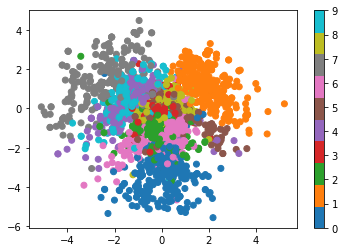

In [17]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

In [18]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [19]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

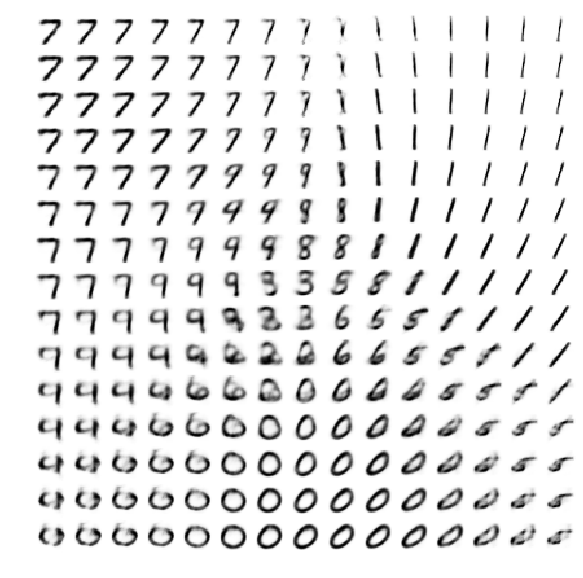

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# Draw
### 三張混圖，只要三者加起來等於1即可，
### 原本兩兩圖之間的關係是 (1+t)、t，
### 為了要使總合為1，所以用相乘的再做補值。

In [21]:
def inBetween(t,a):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_2 = x_train0[idx_3]
    
    data_t = (1-t)*(1-a)*x_train0[idx_1] + t*(1-0.5*a)*x_train0[idx_2]+ a*(1-0.5*t)*x_train0[idx_3]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_2 = VAE_Encoder.predict(x_train[idx_3:idx_3+1]).squeeze()
    mu_t = (1-t)*(1-a)*mu_0 +t*(1-0.5*a)*mu_1+ a*(1-0.5*t)*mu_2

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(4, 1, 4)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_2[0], mu_2[1])
    ax1.scatter(mu_t[0], mu_t[1])
    

    ax2 = plt.subplot(4, 3, 4)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(4, 3, 5)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(4, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    
    ax4 = plt.subplot(4, 3, 9)
    ax4.imshow(data_2, cmap='Greys')

In [22]:
idx_1, idx_2 , idx_3 = np.random.randint(x_test.shape[0], size=3)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]
data_2 = x_train0[idx_3]

In [23]:
interact(inBetween, t=FloatSlider(value=0.5, min=0, max=1.0,step=0.02,),a=FloatSlider(value=0.5, min=0, max=1.0,step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), FloatSlider(value=0.5, desc…

<function __main__.inBetween(t, a)>